In [1]:
!rm -r sample_data
!git clone https://github.com/uel/BP
!mv -v BP/* .
!rm -r BP

rm: cannot remove 'sample_data': No such file or directory
Cloning into 'BP'...
remote: Enumerating objects: 4764, done.
remote: Counting objects: 100% (1988/1988), done.
remote: Compressing objects: 100% (1984/1984), done.
remote: Total 4764 (delta 7), reused 1976 (delta 1), pack-reused 2776
Receiving objects: 100% (4764/4764), 135.84 MiB | 26.52 MiB/s, done.
Resolving deltas: 100% (38/38), done.
mv: cannot move 'BP/data' to './data': Directory not empty
mv: cannot move 'BP/notebooks' to './notebooks': Directory not empty
renamed 'BP/readme.md' -> './readme.md'
mv: cannot move 'BP/report' to './report': Directory not empty
mv: cannot move 'BP/src' to './src': Directory not empty


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [3]:
def LoadImages(folder):
  res = []
  for filename in sorted(os.listdir(folder)):
    res.append(cv2.imread(os.path.join(folder, filename))/255.)
  return res

In [4]:
with_keyboard = LoadImages("data/2_final/keyboard_detector/with_keyboard")
without_keyboard = LoadImages("data/2_final/keyboard_detector/without_keyboard")
min_class_count = min(len(with_keyboard), len(without_keyboard))
test_size = 0.3
train_count = int(min_class_count * (1 - test_size))
test_count = min_class_count - train_count

x_train = np.array(with_keyboard[:train_count] + without_keyboard[:train_count])
y_train = np.array([1.]*(train_count) + [0.]*(train_count))

x_test = np.array(with_keyboard[-test_count:] + without_keyboard[-test_count:])
y_test = np.array([1.]*(test_count) + [0.]*(test_count))

print(y_train.shape, y_test.shape)

(1214,) (522,)


In [14]:
detection = Sequential()
detection.add(Conv2D(8, (3, 3), activation='relu', input_shape=(180, 320, 3)))
detection.add(MaxPooling2D((2, 2)))
detection.add(Conv2D(16, (3, 3), activation='relu'))
detection.add(MaxPooling2D((2, 2)))
detection.add(Conv2D(32, (3, 3), activation='relu'))
detection.add(MaxPooling2D((2, 2)))
detection.add(Conv2D(64, (3, 3), activation='relu'))
detection.add(MaxPooling2D((2, 2)))
detection.add(Conv2D(128, (3, 3), activation='relu'))
detection.add(MaxPooling2D((2, 2)))
detection.add(Flatten())
detection.add(Dense(32, activation='relu'))
detection.add(Dense(1, activation='sigmoid'))
detection.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


detection.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=8)
detection.save("models/detection.h5")
print(f'Model size: {os.stat("models/detection.h5").st_size / (1024 * 1024)}MB')

Epoch 1/10
152/152 [==============================] - 8s 19ms/step - loss: 0.2551 - accuracy: 0.8979 - val_loss: 0.1397 - val_accuracy: 0.9444
Epoch 2/10
152/152 [==============================] - 2s 11ms/step - loss: 0.0794 - accuracy: 0.9843 - val_loss: 0.7773 - val_accuracy: 0.7816
Epoch 3/10
152/152 [==============================] - 2s 13ms/step - loss: 0.0849 - accuracy: 0.9761 - val_loss: 0.0310 - val_accuracy: 0.9962
Epoch 4/10
152/152 [==============================] - 2s 11ms/step - loss: 0.0449 - accuracy: 0.9876 - val_loss: 0.0293 - val_accuracy: 0.9923
Epoch 5/10
152/152 [==============================] - 2s 11ms/step - loss: 0.0383 - accuracy: 0.9926 - val_loss: 0.0179 - val_accuracy: 0.9962
Epoch 6/10
152/152 [==============================] - 2s 10ms/step - loss: 0.0279 - accuracy: 0.9959 - val_loss: 0.0305 - val_accuracy: 0.9923
Epoch 7/10
152/152 [==============================] - 2s 10ms/step - loss: 0.0674 - accuracy: 0.9786 - val_loss: 0.0378 - val_accuracy: 0.9923

17/17 [==============================] - 0s 15ms/step


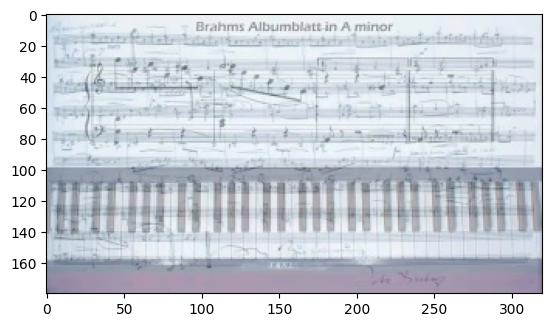

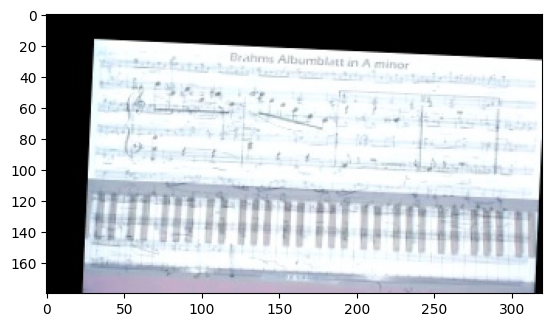

In [16]:
y_pred = detection.predict(x_test)
for i, p in enumerate(y_pred):
  if round(float(p)) != y_test[i]:
    plt.figure()
    plt.imshow(x_test[i])
    plt.show()
    print()